# Vision Transformer

![](images/vit.png)

## Import all necessary libraries

In [1]:
import os
import time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (
    Layer,
    Dense,
    Conv2D,
    Flatten,
    Add,
    Embedding,
    LayerNormalization,
    MultiHeadAttention,
)

%matplotlib inline

## Configure the hyperparameters

In [2]:
image_size = 72  # We'll resize input images to this size

# ViT config
num_class = 100
patch_size = 6
num_patches = (image_size // patch_size) ** 2
embed_dim = 64
num_heads = 4
num_layers = 8
mlp_dim = 1024

# For training
batch_size = 256
num_epochs = 10

## Prepare the data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

# assert x_train.shape == (50000, 32, 32, 3)
# assert x_test.shape == (10000, 32, 32, 3)
# assert y_train.shape == (50000, 1)
# assert y_test.shape == (10000, 1)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [4]:
train_split = 0.9
num_train = x_train.shape[0]

train_size = int(train_split * num_train)

x_training, y_training = x_train[:train_size], y_train[:train_size]
x_validation, y_validation = x_train[train_size:], y_train[train_size:]

print(f"x_train shape: {x_training.shape} - y_train shape: {y_training.shape}")
print(f"x_validation shape: {x_validation.shape} - y_validation shape: {y_validation.shape}")

x_train shape: (45000, 32, 32, 3) - y_train shape: (45000, 1)
x_validation shape: (5000, 32, 32, 3) - y_validation shape: (5000, 1)


### Data Preprocess and Augmentation

In [5]:
train_data = tf.data.Dataset.from_tensor_slices((x_training, y_training))
validation_data = tf.data.Dataset.from_tensor_slices((x_validation, y_validation))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

### pre-processing and augmentation
resize_norm_layers = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(image_size, image_size),
    ],
    name="resize_norm"
)

# Compute the mean and the variance of the training data for normalization.
resize_norm_layers.layers[0].adapt(x_train)

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

train_ds = train_data.shuffle(buffer_size=10000)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.map(
    lambda x, y: (resize_norm_layers(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation_ds = validation_data.shuffle(buffer_size=10000)
validation_ds = validation_ds.batch(batch_size)
validation_ds = validation_ds.map(
    lambda x, y: (resize_norm_layers(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_ds = test_data.shuffle(buffer_size=10000)
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.map(
    lambda x, y: (resize_norm_layers(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Show the dataset

(72, 72, 3)
tf.Tensor([43], shape=(1,), dtype=int64)


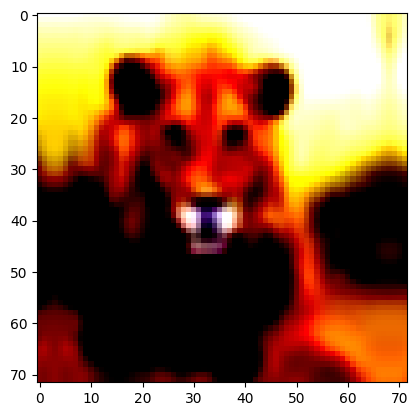

In [6]:
# showing dataset
for image, label in train_ds.take(1):
    print(image[0].shape)
    print(label[0])
    plt.imshow(image[0])

## Build the ViT model

### 1. Implement patch creation as a layer

#### Patch image with ` tf.image.extract_patches`

We use [tf.image.extract_patches](https://www.tensorflow.org/api_docs/python/tf/image/extract_patches) to extract patches from images, as below:


In [7]:
test_image = cv2.imread("images/dog.jpg")
test_image = cv2.resize(test_image, (256, 256))
test_image = tf.expand_dims(test_image, axis=0)

In [8]:
patches = tf.image.extract_patches(images=test_image,
                                   sizes=[1, 16, 16, 1],
                                   strides=[1, 16, 16, 1],
                                   rates=[1, 1, 1, 1],
                                   padding='VALID')
flattened_patches = tf.reshape(patches, (patches.shape[0], -1, 768))
print(patches.shape)
print(flattened_patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


##### Display patches for sample image

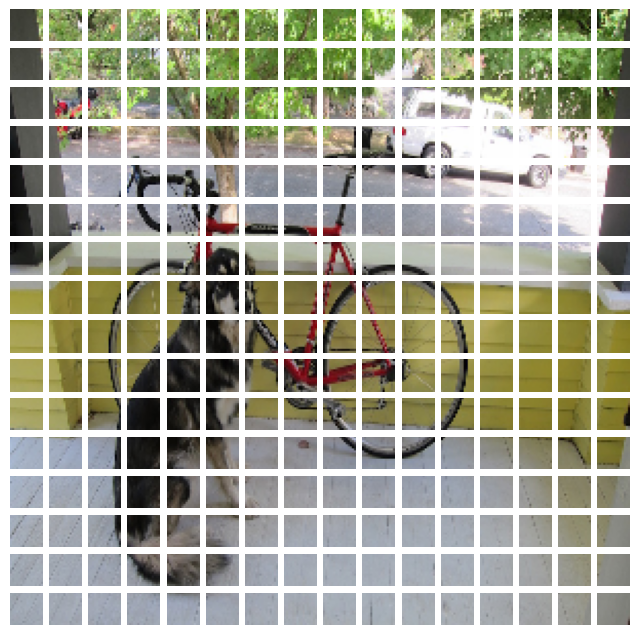

In [9]:
plt.figure(figsize=(8,8))
k = 0
for i in range(16):
    for j in range(16):
        ax = plt.subplot(16, 16, k+1)
        patch_img = tf.reshape(patches[0,i,j,:], (16,16,3))
        patch_img_numpy = patch_img.numpy().astype("uint8") # BGR
        plt.imshow(cv2.cvtColor(patch_img_numpy, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        k+=1

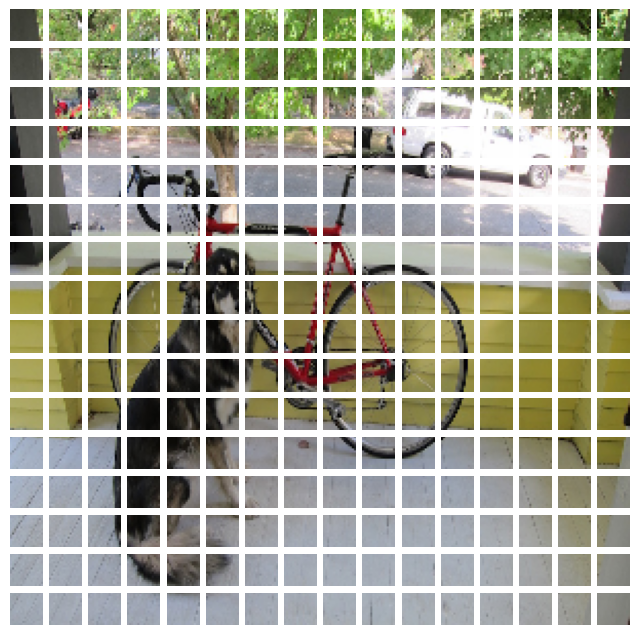

In [10]:
plt.figure(figsize=(8,8))
for i in range(flattened_patches.shape[1]):
        ax = plt.subplot(16, 16, i+1)
        patch_img = tf.reshape(flattened_patches[0,i,:], (16,16,3))
        patch_img_numpy = patch_img.numpy().astype("uint8") # BGR
        plt.imshow(cv2.cvtColor(patch_img_numpy, cv2.COLOR_BGR2RGB))
        plt.axis("off")

#### Build the Patch Layer

In [11]:
class Patches(Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__(name = 'patches')

        self.patch_size = patch_size

    def call(self, x):
        batch_size, height, width, channels = x.shape

        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size

        patches = tf.image.extract_patches(images=x,
                                           sizes=[1, self.patch_size, self.patch_size, 1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        flattened_patches = tf.reshape(patches, (tf.shape(patches)[0], -1, patches.shape[-1]))

        return flattened_patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

##### Display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


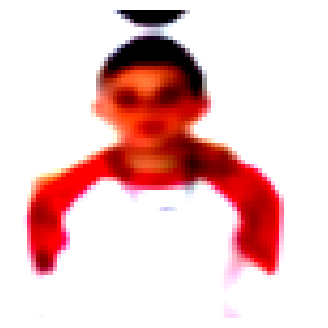

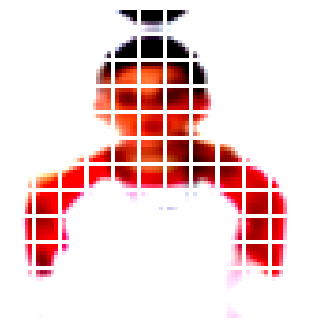

In [12]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(4, 4))
    plt.imshow(images[0])
    plt.axis("off")

    patches = Patches(patch_size)(images)
    print(f"Image size: {image_size} X {image_size}")
    print(f"Patch size: {patch_size} X {patch_size}")
    print(f"Patches per image: {patches.shape[1]}")
    print(f"Elements per patch: {patches.shape[-1]}")

    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(4, 4))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        patch_img_numpy = patch_img.numpy()
        plt.imshow(patch_img_numpy)
        plt.axis("off")

### 2. Implement PatchEncoder layer

In [13]:
class PatchEncoder(Layer):
    # embed_dim: hidden size or projection_dim)
    def __init__(self, num_patches, embed_dim):
        super(PatchEncoder, self).__init__(name = 'patch_encoder')

        self.num_patches = num_patches
        self.linear_projection = Dense(embed_dim)
        self.positional_embedding = Embedding(input_dim=num_patches, output_dim=embed_dim)

    def call(self, patch):
        positions = tf.range(0, self.num_patches, delta=1)
        projected_patches = self.linear_projection(patch)
        encoded = projected_patches + self.positional_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [14]:
# image_size = 256  # We'll resize input images to this size
# patch_size = 16   # Size of the patches to be extract from the input images
# num_patches = (image_size // patch_size) ** 2

patch_enc = PatchEncoder(256, 768)
config = patch_enc.get_config()
print(patch_enc(tf.zeros([1,256,768])))

tf.Tensor(
[[[ 0.03127578  0.03985456  0.0162578  ... -0.02270895 -0.02485672
    0.03765624]
  [ 0.001842   -0.01953315  0.00981426 ...  0.03127528 -0.03348986
   -0.01236564]
  [ 0.00738894 -0.04244256  0.04451248 ...  0.02276169 -0.01802152
    0.00196079]
  ...
  [-0.01261642  0.00757412  0.04268289 ...  0.04585138  0.02609887
   -0.02028582]
  [ 0.03834028  0.03546424  0.04147044 ...  0.00244568  0.03699638
    0.02746281]
  [-0.0400138   0.03476733 -0.00424148 ...  0.03928048  0.00941617
    0.02890253]]], shape=(1, 256, 768), dtype=float32)


### 2. TransformerEncoder

In [15]:
class TransformerEncoder(Layer):
    # embed_dim: hidden size
    def __init__(self, num_heads, embed_dim):
        super(TransformerEncoder, self).__init__(name = 'transformer_encode')

        self.layer_norm_1 = LayerNormalization()
        self.layer_norm_2 = LayerNormalization()

        # Create a multi-head attention layer.
        self.multi_head_attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim,
        )

        # MLP: embed_dim -> hidden units
        # TODO: add dropout
        self.dense_1 = Dense(embed_dim, activation = tf.nn.gelu)
        self.dense_2 = Dense(embed_dim, activation = tf.nn.gelu)

    def call(self, input):
        # Layer normalization 1.
        x1 = self.layer_norm_1(input)
        # multi-head attention layer.
        x1 = self.multi_head_attention(x1, x1)

        # Skip connection 1.
        x1 = Add()([x1, input])

        # Layer normalization 2.
        x2 = self.layer_norm_2(x1)

        # MLP.
        x2 = self.dense_1(x2)
        output = self.dense_2(x2)

        # Skip connection 2.
        output = Add()([output, x1])

        return output

In [16]:
trans_enc = TransformerEncoder(8, 768)
print(trans_enc(tf.zeros([1,256,768])))

tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]], shape=(1, 256, 768), dtype=float32)


### 3. ViT

The ViT model consists of multiple Transformer blocks.

In [17]:
class ViT(tf.keras.Model):
    # embed_dim: hidden size
    def __init__(self, num_layers, patch_size, num_patches, embed_dim, num_heads, mlp_dim, num_class):
        super(ViT, self).__init__(name = 'vision_transformer')

        self.num_layers = num_layers

        self.patches = Patches(patch_size)
        self.patch_encoder = PatchEncoder(num_patches, embed_dim)
        self.trans_encoders = [TransformerEncoder(num_heads, embed_dim) for _ in range(self.num_layers)]
        self.dense_1 = Dense(mlp_dim, tf.nn.gelu)
        self.dense_2 = Dense(mlp_dim, tf.nn.gelu)
        self.dense_3 = Dense(num_class) # Logist

    def call(self, input, training = True):
        patches = self.patches(input)
        x = self.patch_encoder(patches)

        for i in range(self.num_layers):
            x = self.trans_encoders[i](x)

        # Create a [batch_size, embed_dim] tensor.
        x = Flatten()(x)

        # MLP Head
        x = self.dense_1(x)
        x = self.dense_2(x)

        # Classify outputs.
        output = self.dense_3(x)

        return output

In [18]:
vit = ViT(
    num_layers=num_layers,
    patch_size=patch_size,
    num_patches=num_patches,
    embed_dim=embed_dim,
    num_heads=num_heads,
    mlp_dim=mlp_dim,
    num_class=num_class
)

# print(vit(tf.zeros([1,144,36,3])))
vit.build(input_shape=(None, 144, 36, 3))

In [19]:
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches (Patches)           multiple                  0         
                                                                 
 patch_encoder (PatchEncode  multiple                  16192     
 r)                                                              
                                                                 
 transformer_encode (Transf  multiple                  74944     
 ormerEncoder)                                                   
                                                                 
 transformer_encode (Transf  multiple                  74944     
 ormerEncoder)                                                   
                                                                 
 transformer_encode (Transf  multiple                  74944     
 ormerEncoder)                                  

## Compile, train, and evaluate the mode

### Compile the model

In [20]:
#learning_rate = 0.001
#weight_decay = 0.0001
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics=[
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
]

In [21]:
vit.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

### Train the model

In [22]:
checkpoint_filepath = "./experiments/checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

In [23]:
history = vit.fit(
    train_ds,
    epochs=10,
    validation_data=validation_ds,
    callbacks=[checkpoint_callback],
)

Epoch 1/10
176/176 [==============================] - 91s 382ms/step - loss: 3.8853 - accuracy: 0.1387 - top-5-accuracy: 0.3566 - val_loss: 3.2985 - val_accuracy: 0.2084 - val_top-5-accuracy: 0.4810
Epoch 2/10
176/176 [==============================] - 64s 361ms/step - loss: 3.0604 - accuracy: 0.2494 - top-5-accuracy: 0.5389 - val_loss: 2.9255 - val_accuracy: 0.2780 - val_top-5-accuracy: 0.5722
Epoch 3/10
176/176 [==============================] - 64s 363ms/step - loss: 2.6894 - accuracy: 0.3220 - top-5-accuracy: 0.6272 - val_loss: 2.7216 - val_accuracy: 0.3154 - val_top-5-accuracy: 0.6236
Epoch 4/10
176/176 [==============================] - 64s 361ms/step - loss: 2.3908 - accuracy: 0.3821 - top-5-accuracy: 0.6929 - val_loss: 2.5664 - val_accuracy: 0.3576 - val_top-5-accuracy: 0.6574
Epoch 5/10
176/176 [==============================] - 64s 364ms/step - loss: 2.1512 - accuracy: 0.4338 - top-5-accuracy: 0.7406 - val_loss: 2.5453 - val_accuracy: 0.3626 - val_top-5-accuracy: 0.6630
Epoch

In [24]:
_, accuracy, top_5_accuracy = vit.evaluate(test_ds)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

40/40 [==============================] - 6s 146ms/step - loss: 2.6665 - accuracy: 0.4042 - top-5-accuracy: 0.7034
Test accuracy: 40.42%
Test top 5 accuracy: 70.34%


## Reference

1. [Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)
2. [Building a Vision Transformers (VIT) with Tensorflow 2 from Scratch - Human Emotions Detection](https://www.youtube.com/watch?v=JcuFQdnawuE)
3. [Neural machine translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer)
